In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow as tf
from tensorflow import keras as K

print('Keras: {}'.format(keras.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Keras: 2.2.0
Tensorflow: 1.8.0


Training Set: (60000, 28, 28), Testing Set: (10000, 28, 28)
(50000,)
(50000,)
(10000,)
(10000,)
----------------------------------------------------------
Training set:(50000, 28, 28), validation set:(10000, 28, 28), test set:(10000, 28, 28)
-----------------------------------------------------------
Extending the dimensions of dataset: 
Training set:(50000, 28, 28, 1), validation set:(10000, 28, 28, 1), test set:(10000, 28, 28, 1)
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 25s 493us/step - loss: 0.2630 - acc: 0.9165 - val_loss: 0.0654 - val_acc: 0.9819
Epoch 2/2
50000/50000 [==============================] - 22s 435us/step - loss: 0.0861 - acc: 0.9725 - val_loss: 0.0444 - val_acc: 0.9874
--------------------------------------
Test loss and test accuracy: 0.03502059142212383 ... 98.81
--------------------------------------


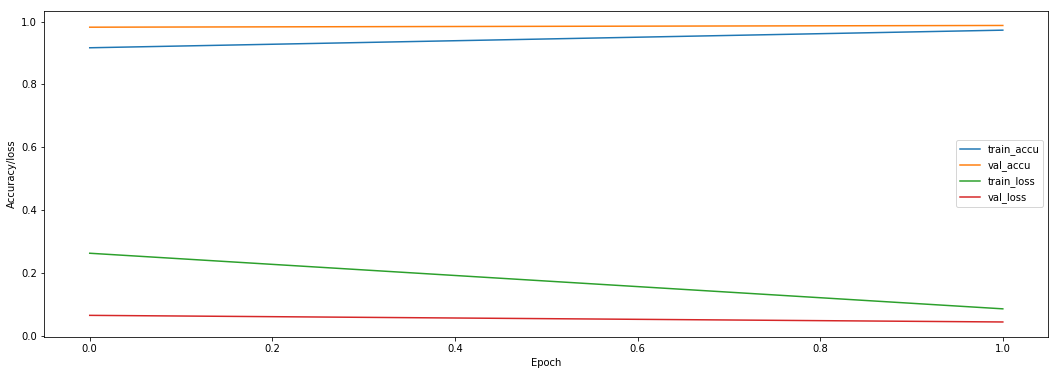

In [52]:
def load_dataset():
    '''Data wrangling and loading training, validation and test set
    '''
    # load dataset
    (train_images, train_labels), (test_images, test_labels) = K.datasets.mnist.load_data(path='/opt/aiml4it-share/public-training-sets/mnist/mnist.npz')
    
    # print shape of dataset
    print("Training Set: {}, Testing Set: {}".format(train_images.shape, test_images.shape))
    
    # splitting train images to make validation set for training purposes
    val_images = train_images[50000:]
    val_labels = train_labels[50000:]

    train_images = train_images[:50000]
    train_labels = train_labels[:50000]

    # convert class vectors to binary class matrices
    print(train_labels.shape)
    #train_labels = K.utils.to_categorical(train_labels) 
    print(train_labels.shape)
    #val_labels = K.utils.to_categorical(val_labels) 
    print(val_labels.shape)
    #test_labels = K.utils.to_categorical(test_labels)
    print(test_labels.shape)
    
    print('----------------------------------------------------------')
    print('Training set:{}, validation set:{}, test set:{}' .format(train_images.shape, val_images.shape, test_images.shape))
    print('-----------------------------------------------------------')
    
    # convert class vectors to binary class matrices
    # train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    # val_labels = tf.keras.utils.to_categorical(val_labels, 10)
    # test_labels = tf.keras.utils.to_categorical(test_labels, 10)
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

def scale_pixels(train, val, test):
    '''Normalize pixels values and expanding the dimensions from (28, 28) to (28, 28, 1)
    '''
    # Convert from integer to float values
    train, val, test = train.astype('float32'), val.astype('float32'), test.astype('float32')
    
    # Scale pixels between [0, 1]
    train, val, test = train / 255.0, val / 255.0, test / 255.0
    
    # Expanding the dimension of the images to make it (28, 28, 1)
    train, val, test  = np.expand_dims(train, axis=-1), np.expand_dims(val, axis=-1), np.expand_dims(test, axis=-1)
    
    print('Extending the dimensions of dataset: ')
    print('Training set:{}, validation set:{}, test set:{}' .format(train.shape, val.shape, test.shape))
    
    return train, val, test

def cnn_model():
    # Model arhitecture
    inputs = K.layers.Input(shape=(28, 28, 1))
    c = K.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(inputs)
    m = K.layers.MaxPool2D((2,2), (2, 2))(c)
    d = K.layers.Dropout(0.5)(m)
    c = K.layers.Conv2D(64, (3, 3), padding='valid', activation='relu')(d)
    m = K.layers.MaxPool2D((2,2), (2, 2), name='conv')(c)
    d = K.layers.Dropout(0.5)(m)
    c = K.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')(d)
    f = K.layers.Flatten()(c)
    outputs = K.layers.Dense(10, activation=tf.nn.softmax, name='preds')(f)

    # Creating model object by inserting inputs and outputs to the model
    model = K.models.Model(inputs, outputs)

    # Compilation of the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def loss_accuracy(model):
    plt.plot(model.history['acc'], label='train_accu')
    plt.plot(model.history['val_acc'], label = 'val_accu')
    plt.plot(model.history['loss'], label='train_loss')
    plt.plot(model.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy/loss')
    plt.legend()
    
    
num_classes = 10
epochs = 2

# load dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_dataset()

# Scale images
train_images, val_images, test_images = scale_pixels(train_images, val_images, test_images)

# Model
model = cnn_model()

# Fit model
model.fit(train_images, train_labels, 
          epochs=epochs, 
          validation_data=(val_images, val_labels))

# Plots for accuracy and loss
loss_accuracy(model.history)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('--------------------------------------')
print('Test loss and test accuracy: {} ... {}'.format(test_loss, test_acc*100))
print('--------------------------------------')

## one-hot encoding converting label vector to class binary matrix

In [54]:
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

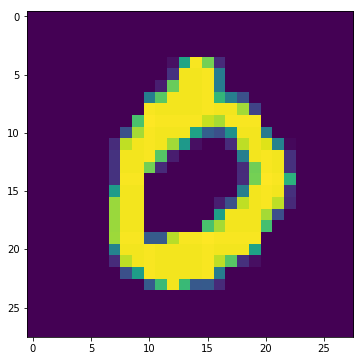

In [55]:
class_idx = 0
indices = np.where(test_labels[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(test_images[idx][..., 0])
idx = indices

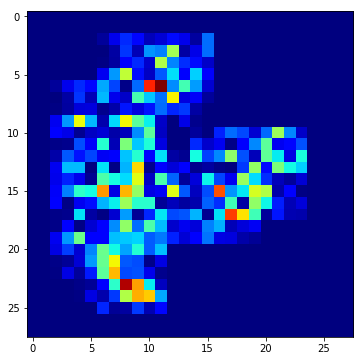

In [56]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'conv')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_images[idx])

# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

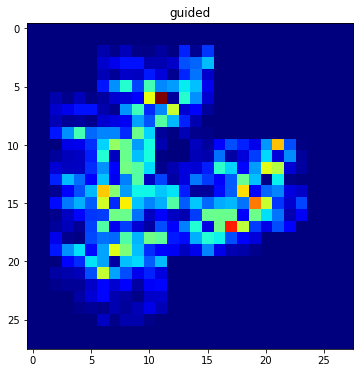

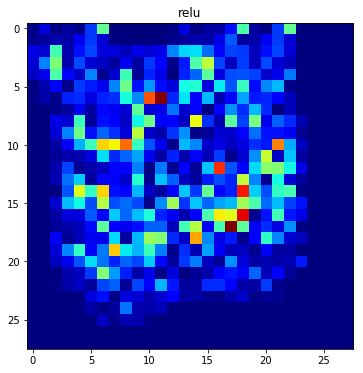

In [57]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=test_images[idx], backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')

We can also visualize negative gradients to see the parts of the image that contribute negatively to the output by using grad_modifier='negate'.

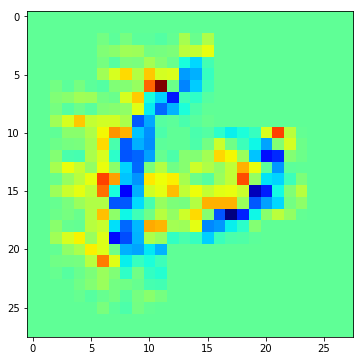

In [58]:
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=test_images[idx], 
                           backprop_modifier='guided', grad_modifier='negate')

plt.imshow(grads, cmap='jet')

Lets try all the classes and show original inputs and their heatmaps side by side. We cannot overlay the heatmap on original image since its grayscale.

We will also compare the outputs of guided and rectified or deconv saliency.

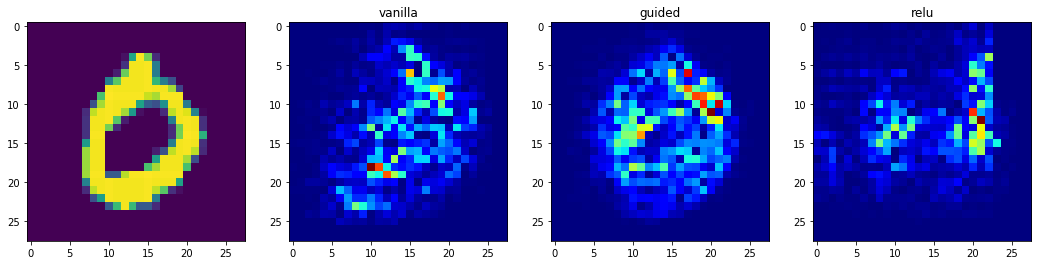

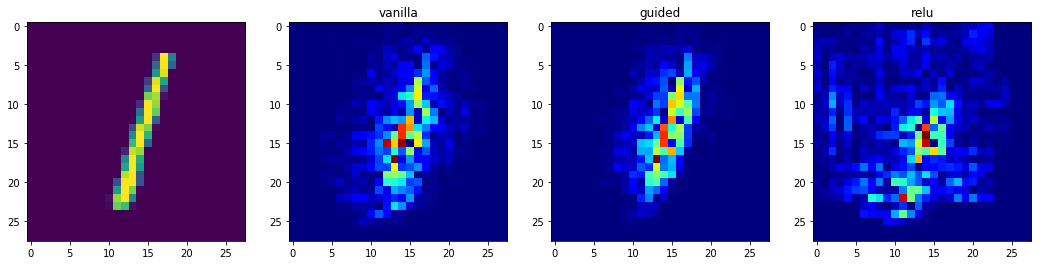

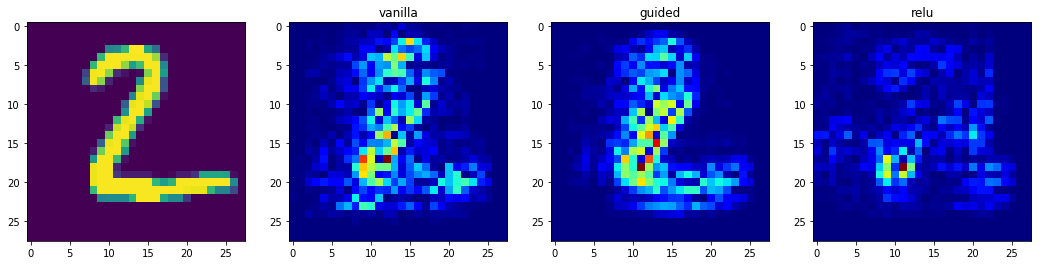

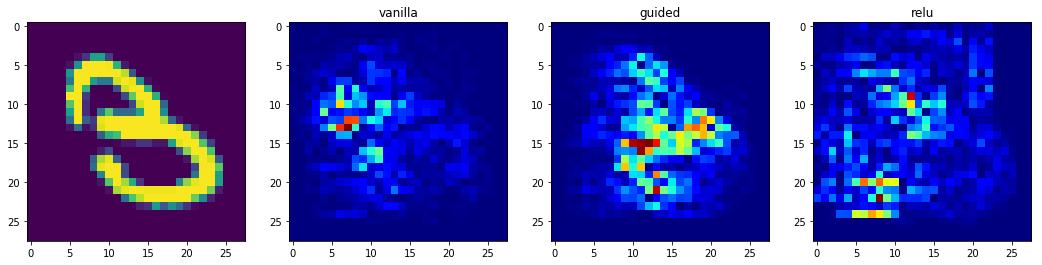

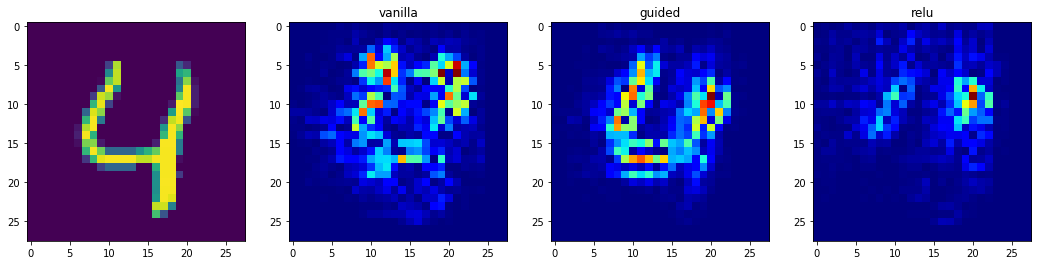

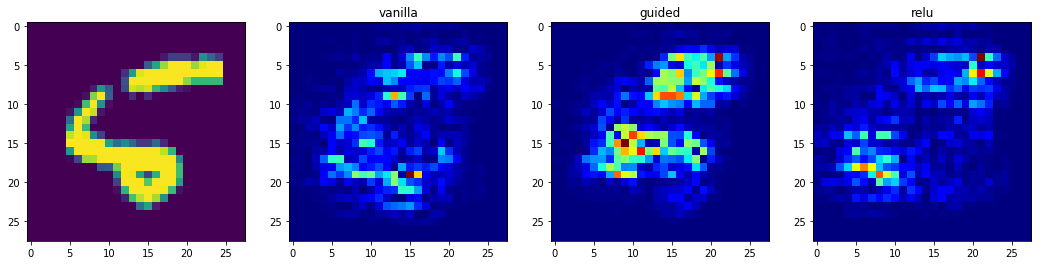

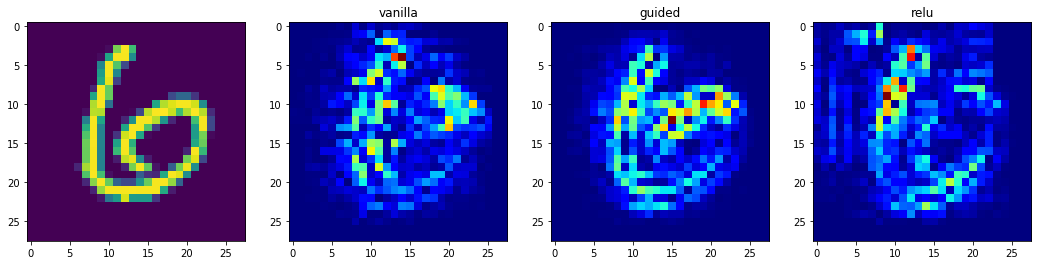

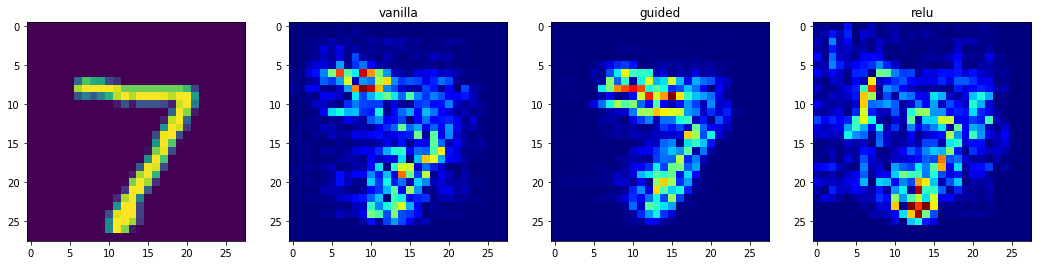

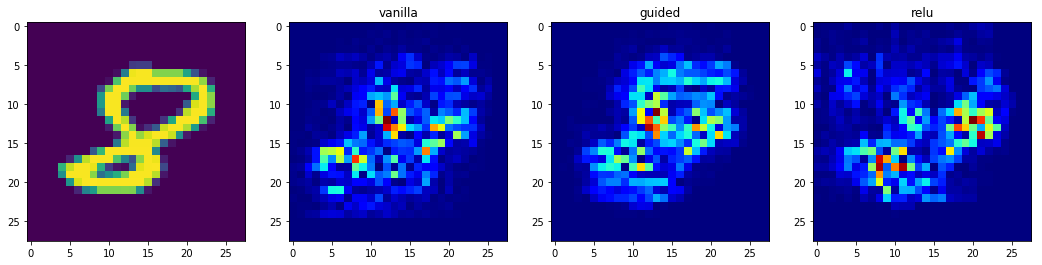

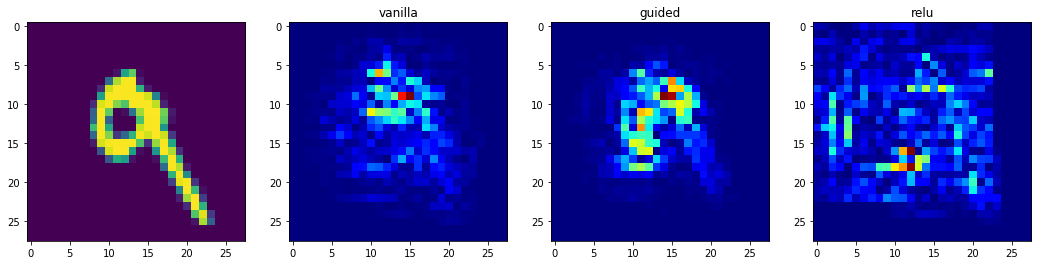

In [59]:
# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(test_labels[:, class_idx] == 1.)[0]
    idx = indices[0]
    layer_idx = -1

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_images[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=test_images[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

# grad-CAM - vanilla, guided, rectified¶

These should contain more detail since they use Conv or Pooling features that contain more spatial detail which is lost in Dense layers. The only additional detail compared to saliency is the penultimate_layer_idx. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if penultimate_layer_idx is not defined, it searches for the nearest pre layer. For our architecture, that would be the MaxPooling2D layer after all the Conv layers. Lets look at all the visualizations like before.

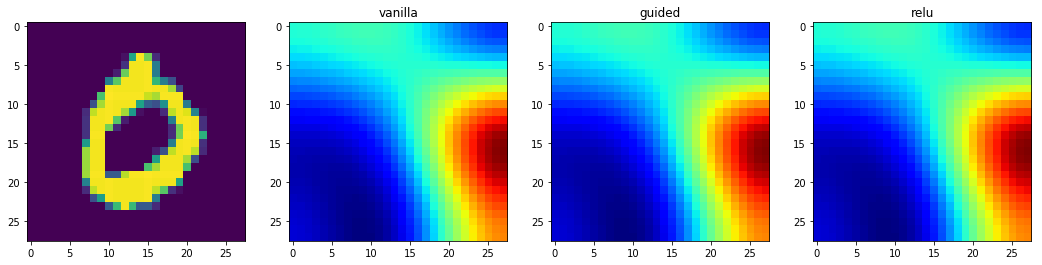

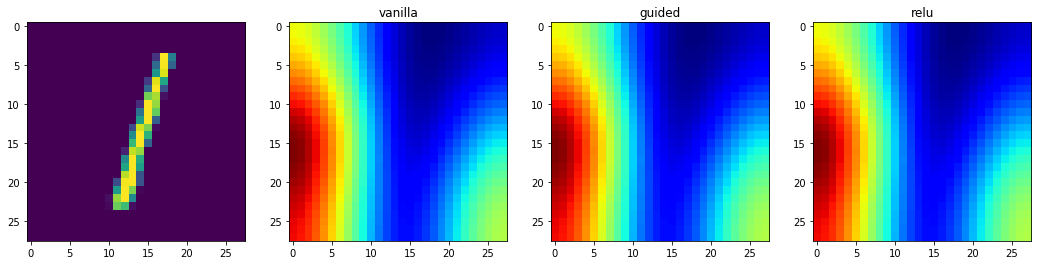

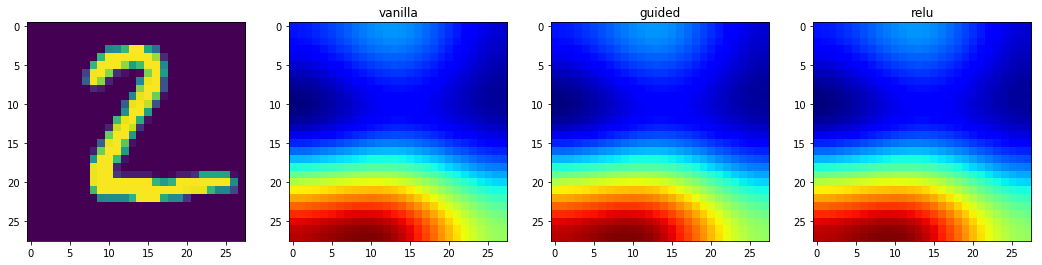

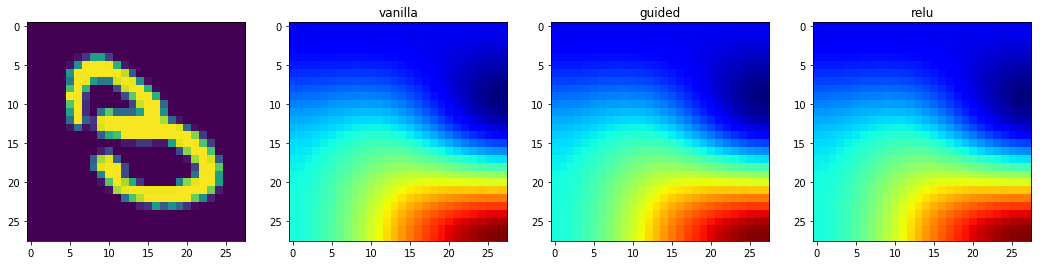

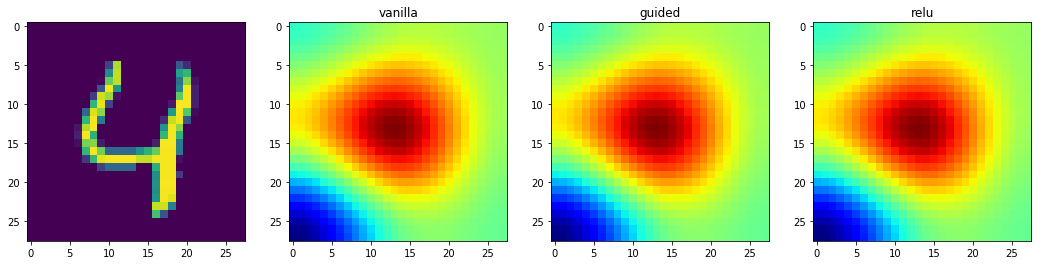

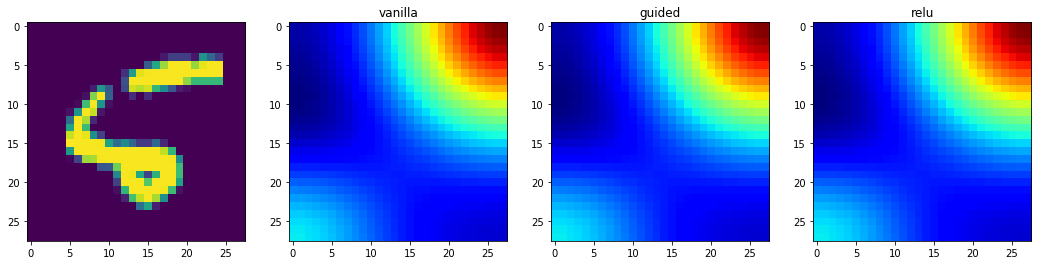

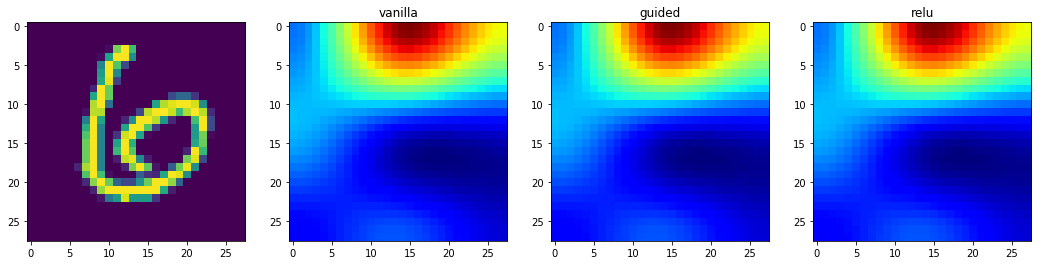

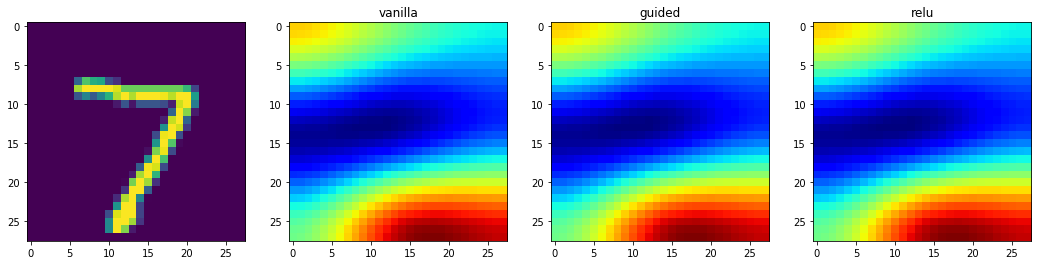

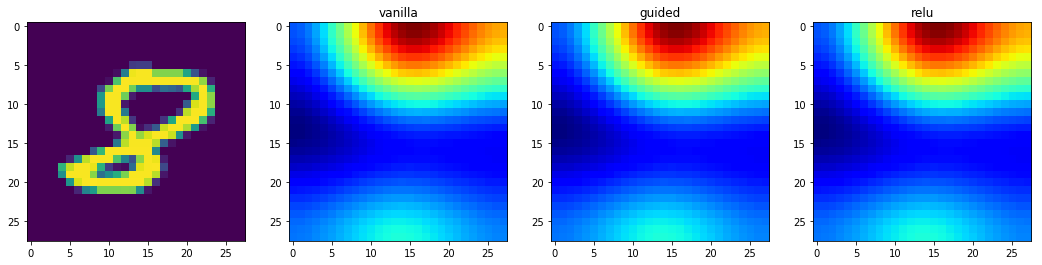

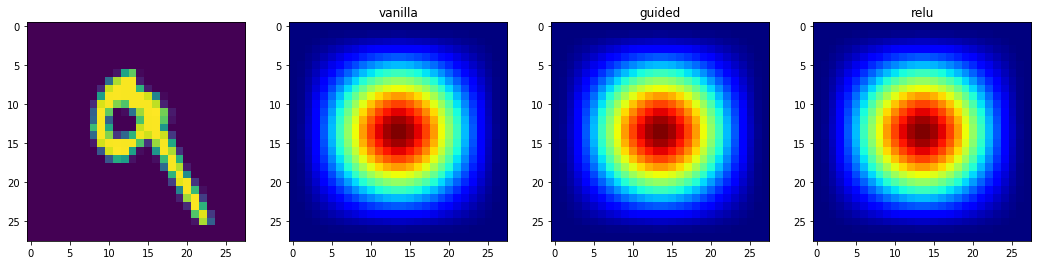

In [60]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for class_idx in np.arange(10):    
    indices = np.where(test_labels[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(test_images[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, 
                              seed_input=test_images[idx], backprop_modifier=modifier)        
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')

In this case it appears that saliency is better than grad-CAM as penultimate MaxPooling2D layer has (12, 12) spatial resolution which is relatively large as compared to input of (28, 28). Is is likely that the conv layer hasnt captured enough high level information and most of that is likely within dense_4 layer.

Here is the model summary for reference.

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5, 64)          0         
__________

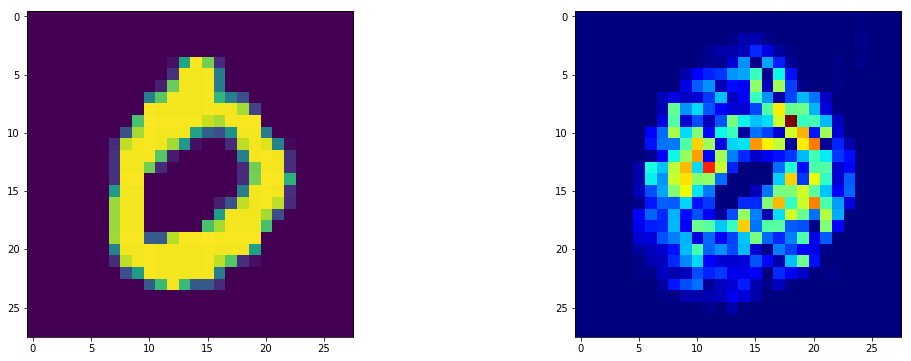

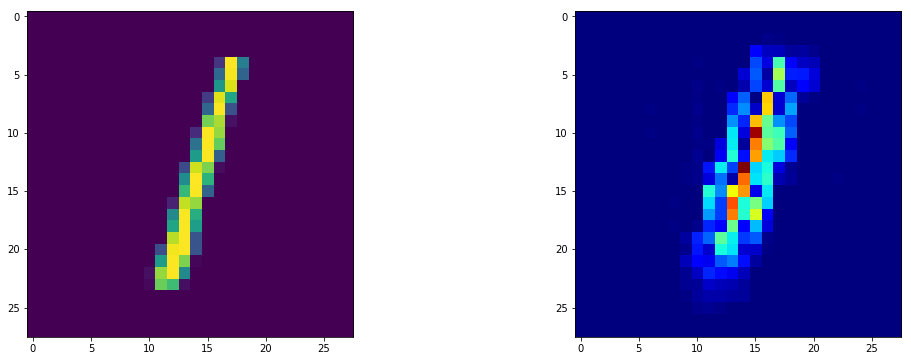

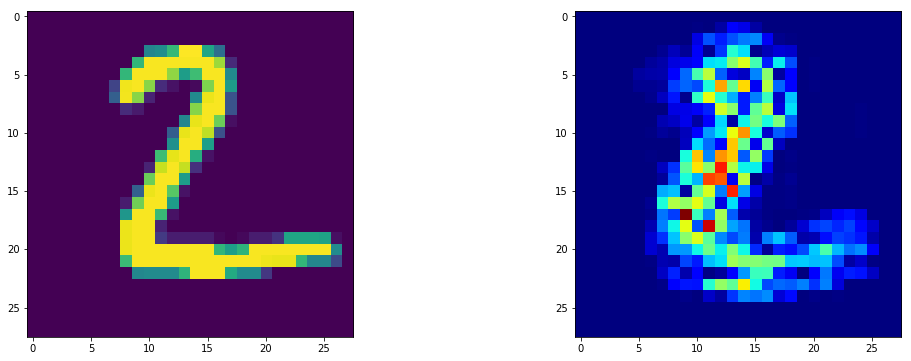

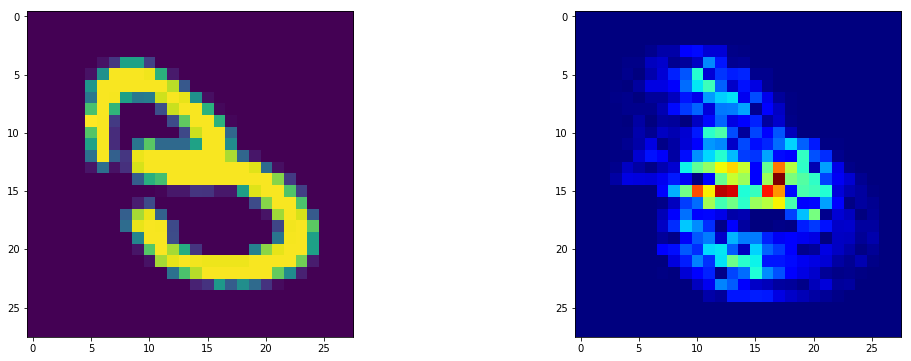

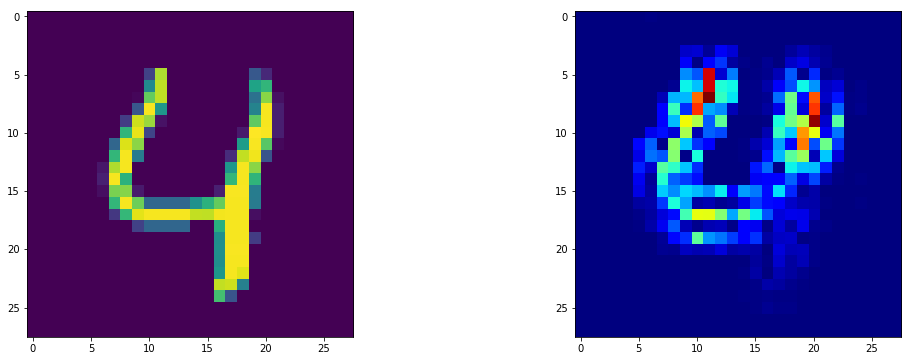

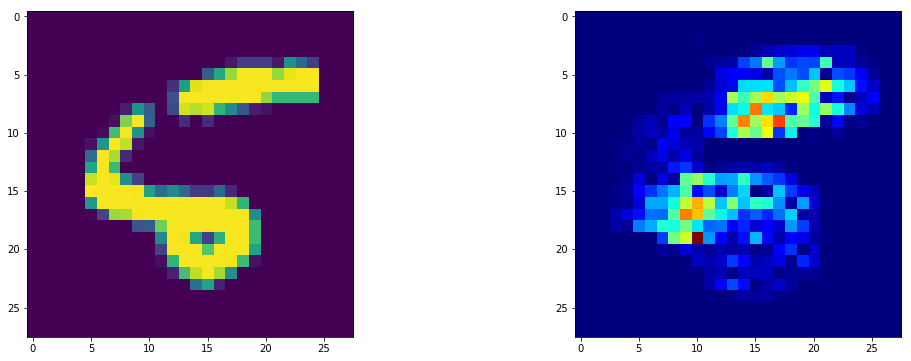

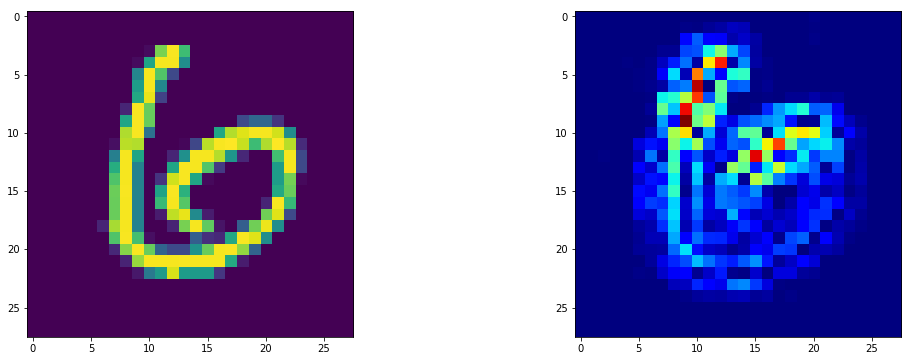

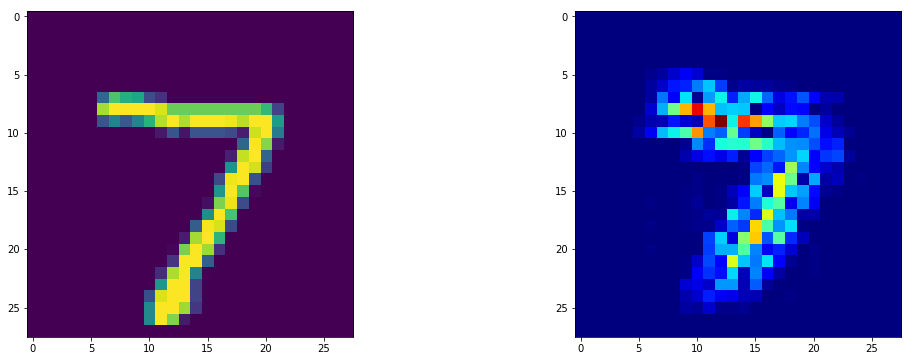

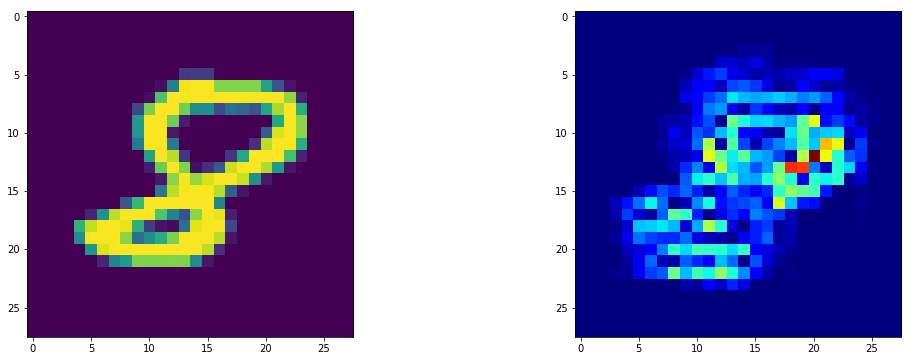

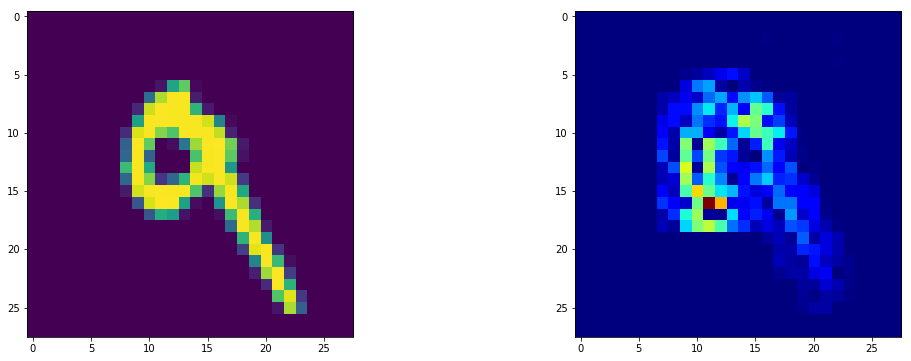

In [51]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in np.arange(10):    
    indices = np.where(test_labels[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                               seed_input=test_images[idx], backprop_modifier='guided')

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(test_images[idx][..., 0])
    ax[1].imshow(grads, cmap='jet')
